# Stable Diffusion quantization example

<b>Stable Diffusion (SD)</b> is a [Latent Diffusion Model (LDM)](https://arxiv.org/pdf/2112.10752), capable of generating images either conditionally (e.g., from text) or unconditionally.  

In this notebook, we will implement SD inference from scratch, and then apply <b> quantization </b> to improve inference performance.

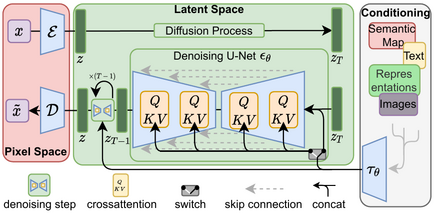

### 0. Install Dependencies

In [3]:
# !pip install -r requirements.txt

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler, StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

from utils import sd_inference

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "sd-legacy/stable-diffusion-v1-5"
prompt = "Big dog in a river"
num_inference_steps = 50
guidance_scale=7.5

### 1. Original SD result

In [4]:
scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
pipe.scheduler.set_timesteps(num_inference_steps)
with torch.autocast(device):
    image = pipe(prompt, guidance_scale=guidance_scale).images[0]
del pipe

C:\Users\karae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\clip\modeling_clip.py:546: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/50 [00:00<?, ?it/s]

This is how original SD pipeline result looks like:

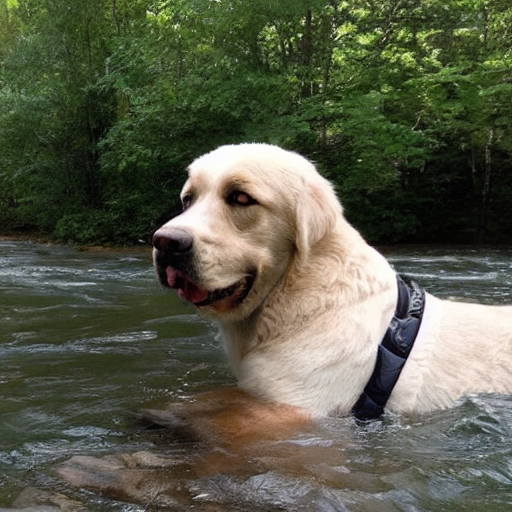

In [6]:
image

### 2. SD inference from scratch
First, we need to load main parts of Stable Diffusion:


🔹 CLIP Tokenizer + Text Encoder — Encodes text prompts into conditioning vectors  
🔹 U-Net — The denoiser: iteratively refines the latent image representation  
🔹 VAE Decoder — Projects the final latent representation back into pixel space (i.e., the actual image)  
🔹 DDIM Scheduler — Adapts step size and noise removal to reduce steps size (to 30-50)

In [22]:
device = "cuda"
model_id = "sd-legacy/stable-diffusion-v1-5"
n_timestamps = 50

# Initialize everything
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
# scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
scheduler.set_timesteps(n_timestamps)

# Set up prompt
prompt = "big dog in river"

# Summarize
no_quantization_params = {"tokenizer": tokenizer,
                          "text_encoder": text_encoder,
                          "unet": unet,
                          "scheduler": scheduler,
                          "vae": vae,
                          "text_prompt": prompt,
                          "device": device,
                         "guidance_scale": guidance_scale}

In [23]:
# Run inference
image_no_quant = sd_inference(**no_quantization_params)

100%|██████████| 51/51 [00:10<00:00,  4.78it/s]


This is an image we get without quantization

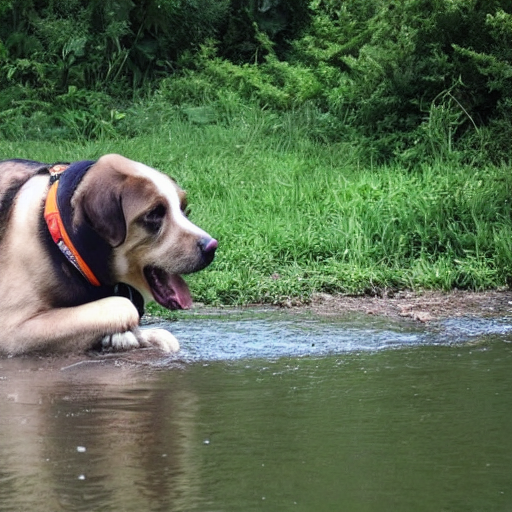

In [24]:
image_no_quant

### 3. Quantization of  weights & quantized inference

In this part we will convert weights to INT8 with even and uneven quantization to reduce model weight

In [ ]:
# Coming soon...